# Programming for Data Analysis Project

## The Task
For this project I will be synthesizing a dataset, to do so I will be using various functions of the numpy.random package to create interpretations of real world phenomenon, a lot of the work done for this notebook will be in determining what this data looks like in reality so that the synthetic data is a fairly good reflection of it.

An example to illustrate this (as provided by the lecturer), is to consider students enrolled in a module, based on this example it seems sensible to consider each student has a grade at the end of a module and as we know from the common misconception that lecturers grade to a bell curve, is in fact due to the how phenomenon such as this tends to follow a normal distribution.
Following on from this we can assert that there are other factors that will help to determine their grade, such as their level of education going into this module (it stands to reason that someone with a PhD will in general outperform someone who has a bachelors degree), the amount of hours a student studies is also probably effecting their grade as is perhaps whether the student is full time or part time.  

## My Synthetic Data Idea -  A representation of Irish adults prior to retirement Gender, Height, Weight and Age

My idea here is to simulate a dataset for adults based on their Gender, Height, Weight and Age, for this I will be considering only those from the age of 18 to 64.

- Gender is straight forward to start with as the population can be reasonably divided into half female and half male.

- Age is another direct factor to consider as it is wiill be independent of height and weight as neither of these will influence someones age.

- Height will be exclusively influenced by their gender, one of the assumptions made here is that a person stops getting taller after 18, which is not strictly true and likewise as people get past a certain age they also do lose some height.

- Weight will be influenced by all of the other factors, as someones gender and height will factor into their weight, determining weight will be broken up into two steps.
    - First is to determine their BMI category using the proportion of the population by gender that fall under each of the BMI categories.
    - Second is to use that BMI category to determine a value for BMI and using that value with the previously determined height, calculate the weight.

### Exploring the variables in more detail and their relationships


In general with dependent and independent variables a variable can only be one or the other, however for this project as I am generating the variables in different steps I think it is fair to say that they all are dependent varaibles in a certain context, even though they are not directly influenced by the other variables within the dataset. 

What I mean by this is that Gender is something that is technically an independent variable for each of the other variables but when generating the different genders it is itself effected by the proportion of the overall population, which I will be using to determine the likelihood of any individual being female or male, therefore in that context Gender is a dependent variable and the independent variable is the female to male ratio of the population in Ireland.

#### Dependent variables and the Independent Variables that effect them
[Gender] <= [Proportion of Females to Males in Population]

[Age] <= [Proportion of Ages in Population], [Gender]

[Height] <= [Gender]

[Weight] <= [Gender], [Height]

***

## Determining Gender and Age using 2016 Census Data

On the face of it gender appears to be an easy 50 50 chance but for the sake of accuracy and to check the veracity of that claim I took a look at the Central Statistics Office (CSO) Census data for Men and Women, handily the CSO page also includes information for their ages as well.
[Link to CSO page on Men and Women](https://www.cso.ie/en/releasesandpublications/ep/p-cp3oy/cp3/assr/)

Based on the most recent census data (from 2016) the ratio of men to women is not quite equal, there is a minor difference between the ratio of men to women between the ages 15-64 of 980 men to 1000 women. More interestingly however the ratio of men to women broadens significantly when looking at the 65+ age group with 871 men to 1000 women.

Looking more indepth into the data we can more accurately determine how age is distributed from the ages of 18-64 as the census data is freely available to download, I took a look at the dataset and have used it to determine the actual ratio of Female's to Male's  across the Irish population (as of 2016 at least), with this dataset I have also been able to determine how age is distributed across the genders also.

As mentioned above, this dataset was taken from the CSO https://data.cso.ie/table/EY007 (you can find the downloaded dataset in csv format in the Data folder of this repository), it contains the Census data for 2016 which gives the numbers of individuals by gender across different ages.

In [1]:
#Setting up imports for the rest of the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)}) #setting seaborn plot size
plt.style.use('ggplot') #setting plot style

In [21]:
#Seed a random number generator
rng = np.random.default_rng(1)

cso_df = pd.read_csv('Data\cso population 2011-2016.csv') #reading in csv file for dataset

#filter down to 2016, filter out all rows containing Both Sexes and include only rows showing population 
cso_df = cso_df[(cso_df['CensusYear']==2016) & (cso_df['Sex']!='Both sexes') & (cso_df['At Each Year of Age']=='Population') ] 

#Convert column containing age to be numeric and assign to new column
cso_df['Age'] = pd.to_numeric(cso_df['C02076V03371'],errors='coerce')

#drop unecessary columns as there is a lot of unecessary columns and confusingly named
cso_df = cso_df.drop(['STATISTIC', 'C02199V02655', 'Age Last Birthday', 'At Each Year of Age', 'UNIT', 'C02076V03371', 'C02786V03355', 'C02786V03355', 'TLIST(A1)', 'Statistic'], axis=1)

#filter down to the age group of interest 18 to 64
cso_df = cso_df[(cso_df['Age'] >=18) & (cso_df['Age'] <=64)].reset_index(drop=True)

#subset the dataframe into a male and female set, this is done to make getting proportions of the population simpler
cso_male_df = cso_df[cso_df['Sex']=='Male'].reset_index(drop=True)
cso_female_df = cso_df[cso_df['Sex']=='Female'].reset_index(drop=True)

# Now that dataframes have been cleaned and subsetted to the relevant data and groupings, 
# can get some statistics on the population

#get total female population
total_female_pop = cso_female_df['VALUE'].sum()
#get total male population
total_male_pop = cso_male_df['VALUE'].sum()
#total population as sum of female and male population
total_pop = total_male_pop + total_female_pop
#get percentage of population female
female_percentage = total_female_pop/total_pop
#get percentage of population male
male_percentage = total_male_pop/total_pop
print('Total women between ages 18-64 -', total_female_pop)
print('Total men between ages 18-64 - ', total_male_pop)
print('Total population between ages 18-64 -', total_pop)
print('Females as percentage of population -', female_percentage)
print('Males as percentage of population -', male_percentage)

Total women between ages 18-64 - 1484990
Total men between ages 18-64 -  1448806
Total population between ages 18-64 - 2933796
Females as percentage of population - 0.5061667546073415
Males as percentage of population - 0.49383324539265855


Based on the above I can now start to synthesize some fake data as I now have some representative figures for what percentage of the population Females and Males make up, so this is my first step.

### Generating Gender data

In [3]:
#Creating a dataframe that starts with single column for gender 
df = pd.DataFrame(data=rng.choice(['Female','Male'], size=500, p=[female_percentage, male_percentage]), columns=['Gender'])
#Taking a peak at table so far
df

,Gender
0,Male
1,Male
2,Female
3,Male
4,Female
...,...
495,Male
496,Male
497,Female
498,Male


With the first variable in my dataset generated, I now want to look at adding age, but first I want to use the female and male dataframes from before to determine the probabilities for being a certain age.

To do so I will first create some lists that track the percentage of the population for each age as well as the ages, as these will be added to empty lists during a for loop the index's of the lists will line up.

In [4]:
#Get proportion of male population at different ages
#storing percentage, age, and count in different lists for simplicity and readability as they all get assigned in same loop
#should be no issues with ordering, see commented out dict line's below to see why it was removed
male_age_percentage_list = []
male_age_list = []
male_count_list = []
#male_age_dict = {}
for i in range(len(cso_male_df)):
    #get percentage of males at current age over total male population
    percentage = cso_male_df['VALUE'][i]/cso_male_df['VALUE'].sum()
    #append to list
    male_count_list.append(cso_male_df['VALUE'][i])
    male_age_percentage_list.append(percentage)
    male_age_list.append(int(cso_male_df['Age'][i]))
    #male_age_dict[int(cso_male_df['Age'][i])] = {'Percentage': percentage, 'Number':cso_male_df['VALUE'][i]}

In [5]:
#Get proportion of female population at different ages
female_age_percentage_list = []
female_age_list = []
female_count_list = []
#female_age_dict = {}
for i in range(len(cso_male_df)):
    #get percentage of females at current age over total female population
    percentage = cso_female_df['VALUE'][i]/cso_female_df['VALUE'].sum()
    #append to list
    female_count_list.append(cso_female_df['VALUE'][i])
    female_age_percentage_list.append(percentage)
    female_age_list.append(int(cso_female_df['Age'][i]))
    #female_age_dict[int(cso_female_df['Age'][i])] = {'Percentage': percentage, 'Number':cso_female_df['VALUE'][i]}

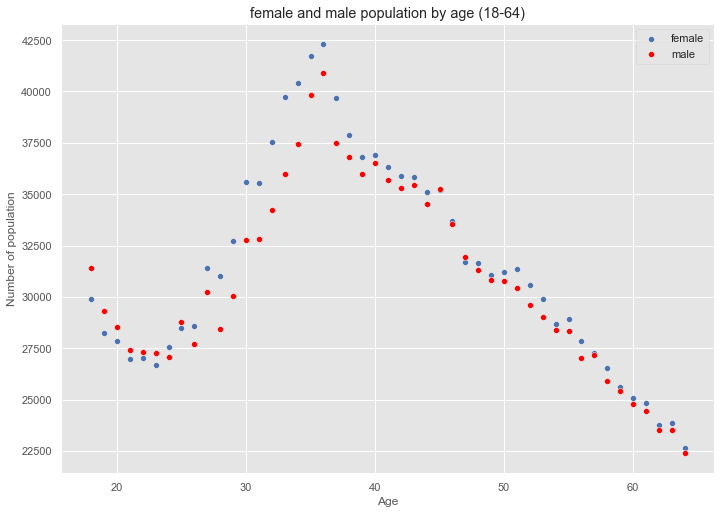

In [6]:
#visualising the distribution of age by gender
sns.scatterplot(x=cso_female_df['Age'],y=cso_female_df['VALUE'], color='b', label='female')
sns.scatterplot(x=cso_male_df['Age'],y=cso_male_df['VALUE'], color='red', label='male')
plt.title('female and male population by age (18-64)')
plt.ylabel('Number of population');

The above scatter plot shows the number of females and males across different ages, and shows that age is indeed not normally distributed therefore I believe the only takeaway I can get from this, is the percentage of the overall population that each age makes up and using that to then determine a persons age by using weighted probabilities with numpy's choice function.

Further inspection of the scatter plot shows a few interesting bits, firstly that there seems to be a trend downwards from teenagers into their twenties, but then a linear population increase for any age up till around 38 years, whereafter it then has a linear descent. The descent after 38 makes sense intuitively to me, naturally as people age they have more chance of having died to some accident or to some disease. what makes less sense is that there is a population dip at around 20 years of age, I would presume that this is due to a tendency in first world countries to have declining birth rates as a country becomes more developed, however this would not explain the fact that there appears to be significantly more 18 and 19 year olds than 22 year olds.


### Generating Age Data
Now that we've determined the probabilities for the various ages across males and females, in the next cell I will use this to assign ages based on the individuals gender. This will update the existing dataframe to now include a new column for our variable Age.

In [7]:
#loop through dataframe with iterrows
for index, row in df.iterrows():
    #if current row's gender is female
    if(row['Gender'] == 'Female'):
        #Age is set using numpy's choice function, within potential ages in female_age_list and corresponding probabilities in female_age_percentage_list
        df.at[index,'Age'] = rng.choice(female_age_list, p=female_age_percentage_list)
    elif(row['Gender'] == 'Male'):
        df.at[index,'Age']  = rng.choice(male_age_list, p=male_age_percentage_list)
        
df['Age'] = df['Age'].astype('int') #converting type to int as it defaults to float and want integer for age
df #check data frame so far

,Gender,Age
0,Male,37
1,Male,19
2,Female,26
3,Male,51
4,Female,22
...,...,...
495,Male,43
496,Male,61
497,Female,18
498,Male,57


***
### Brief aside - getting mean and standard deviation for age
In this next section I just wanted to see how the mean and standard deviations varied for men and women, this has no bearing on the dataset but I thought it was interesting.

In [8]:
female_age_sum = 0
female_age_sum_sq = 0
for i in range(len(female_age_list)):
    female_age_sum += female_age_list[i]*female_count_list[i]
mean_female_age = female_age_sum/total_female_pop

female_age_sum_sq = 0
for i in range(len(female_age_list)):
    female_age_sum_sq += female_count_list[i]*((female_age_list[i]-mean_female_age)**2)

stddev_female_age = np.sqrt(female_age_sum_sq/total_female_pop)

print(mean_female_age)
print(stddev_female_age)

40.318919992727224
12.717799985196626


In [9]:
male_age_sum = 0
male_age_sum_sq = 0
for i in range(len(male_age_list)):
    male_age_sum += male_age_list[i]*male_count_list[i]
mean_male_age = male_age_sum/total_male_pop

male_age_sum_sq = 0
for i in range(len(male_age_list)):
    male_age_sum_sq += male_count_list[i]*((male_age_list[i]-mean_male_age)**2)

stddev_male_age = np.sqrt(male_age_sum_sq/total_male_pop)

print(mean_male_age)
print(stddev_male_age)

40.343749266637495
12.814326493317076


Unsurprisingly the mean and standard deviation don't differ much, as we could see from the earlier scatter plot, they tend to track fairly closesly to one another.
***

### Determining and adding Female and Male heights as variables

This was somewhat tricky to find, which was surprising and I could not find any figures specific to Ireland so instead I am using the information available from [OurWorldInData](https://ourworldindata.org/human-height)

The above linked page gives several useful pieces of information for determining height
- Height is normally distributed
- Females have an average height of 164.7cm
    - With a Std. Deviation of 7.07cm
- Males have an average height of 178.4cm
    - With a Std. Deviation of 7.59cm

With the above information I can now start simulating data for adult Female and Male heights, however I would like to point out some of the generalisations made at this point. 

The average height and std. deviations listed above are not necessarily the case for Ireland, in fact they probably aren't totally accurate, however in the absence of any truly accurate figures for Ireland these will make a sufficient approximation.
Additionally the data presented from the link above uses a relatively young group of adults, which may further skew how the average height and std. deviation would be in reality as potentially for adults born in the 1970's their average height could be shorter than adults who were born in more recent years.

That aside, using the figures from above and applying them to my dataset using numpy's normal distribution function is done in the next code cell.

### Generating Height Data

In [22]:
#Loop through each row of dataframe so far and check whether Female or Male
for index, row in df.iterrows():
    #depending on gender use normal distribution with different mean and standard deviation 
    if(row['Gender'] == 'Female'):
        df.at[index,'Height (cm)'] = np.round(rng.normal(loc=164.7,scale=7.59, size=1),2)
    elif(row['Gender'] == 'Male'):
        df.at[index,'Height (cm)']  = np.round(rng.normal(loc=178.4,scale=7.07, size=1),2)

In [23]:
df.describe()

,Age,Height (cm),Weight (KG)
count,500.000000,500.000000,500.000000
mean,41.024000,170.961960,79.028314
std,12.991882,9.538193,22.539331
min,18.000000,146.050000,36.589000
25%,31.000000,163.337500,61.711250
50%,40.000000,171.290000,75.340500
75%,53.000000,178.472500,91.172250
max,64.000000,200.320000,160.024000


In [24]:
df.head()

,Gender,Age,Height (cm),BMI Category,Weight (KG)
0,Male,37,180.84,Overweight,81.655
1,Male,19,184.21,Underweight,46.499
2,Female,26,167.21,Normal weight,54.440
3,Male,51,169.19,Obese,141.961
4,Female,22,171.57,Normal weight,68.189


In [25]:
df.tail()

,Gender,Age,Height (cm),BMI Category,Weight (KG)
495,Male,43,175.72,Normal weight,74.919
496,Male,61,182.37,Obese,120.338
497,Female,18,148.49,Obese,94.126
498,Male,57,180.04,Normal weight,68.511
499,Male,62,178.60,Normal weight,65.089


## Determining Weight using Gender

I will be determining weight using Central Statistics Office Data from 2019 for BMI categories, this is for those 15 years and older which is slightly younger than the dataset aged 18-64 I'm looking at with the synthetic dataset, but I think it is close enough to not present too much of an issue. 

https://data.cso.ie/table/IH308 - CSO dataset for BMI category across age groups.

https://data.cso.ie/table/IH307 - CSO dataset for BMI category across gender.

While we can get data on BMI category by gender and across different age groups, we don't have a combined dataset from the CSO which unfortunately means that we can only look at either in isolation so will have to pick whether to base the BMI category on age groupings or gender.

For the purposes of this synthetic dataset I am going to go with gender.

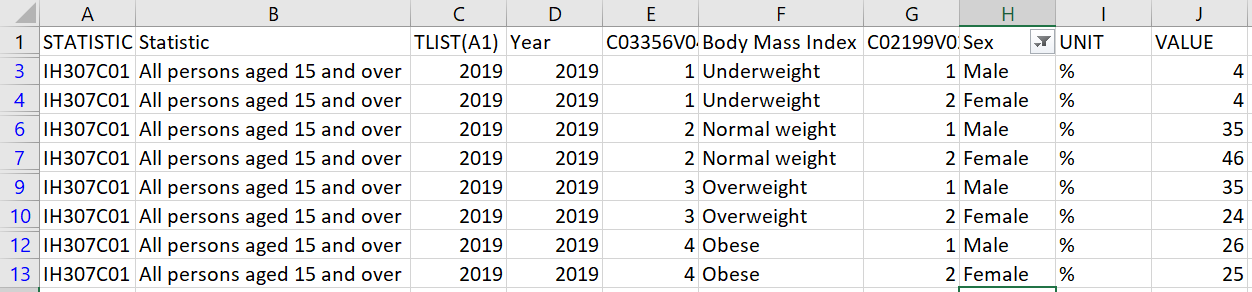

Using the numbers from the BMI category across gender for 2019 gives the following:
- Female
    - Obese 25%
    - Overweight 24%
    - Normal weight 46%
    - Under weight 4%
- Male
    - Obese 26%
    - Overweight 35%
    - Normal weight 35%
    - Under weight 4%
    
As you may have noticed from the above the total percentages for females adds up to ony 99% total which presents a problem for picking an individuals BMI category, this has most likely happened due to rounding of the data by the CSO which has unfortunately resulted in the missing percentage.
To get around this I will be basing the new percentages off the 99% we have available.

Knowing the percentage of women and men that fall under the different BMI categories I am going to use this information to determine for a given individual what category they fall under.

Once it is determined what BMI category they fall under I need to determine their BMI, for 'Normal weight' and 'Overweight' this is pretty straight forward as we know the upper and lower limits of their BMI's and using a uniform distribution I can determine this. However taking this same approach for 'Underweight' and 'Obese' presents a problem, firstly we need to set an upper and lower limit as there's probably no individuals who have a BMI of 0 or 1, similarly for Obese there are probably some people who have a BMI greater than 50 but that is probably less likely than individuals who have a BMI around 35, so I will need to determine some way to account for both of these situations.

From searching I could find no reasonable distributions to represent BMI across 'Underweight' and 'Obese', so if I were to use Normal Distribution's for each I would have to infer a mean and standard deviation value for each instead I'll set some fairly arbitrary upper and lower limits for each and use a Uniform Distribution. - Rationale for this being, that while the dataset is looking at adults across the different BMI categories from under weight to obese it excludes individuals that fall below a BMI of 13 and those above 45.

Once BMI is figured out, weight can easily be calculated using the following formula for BMI as we now know both the height and BMI:
\begin{align}
\ BMI & = \frac{m}{h^{2}} \\
\end{align}

Where m is mass (or Weight) in kg and h is height in cm.

So now to determine weight I will first introduce a new variable for weight category, for whether an individual is health or over weight, then based off that gives a range of possible valeus for BMI within those categories.

In [14]:
bmi_categories = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
p_female_bmi = [.04/0.99,.46/0.99,.24/0.99,.25/0.99] #Unfortunately the provided figures for female bmi percentages only add up to .99
p_male_bmi = [.04,.35,.35,.26]

for index, row in df.iterrows(): #loop through each row in dataframe
    if(row['Gender'] == 'Female'): #if row is gender then there is a 48.4% chance they are over weight
        df.at[index,'BMI Category'] = rng.choice(bmi_categories, p=p_female_bmi)
        if(df.at[index,'BMI Category'] =='Obese'): #depending on whether this person was over or healthy weight
            bmi_lower = 30
            bmi_upper = 45
        elif(df.at[index,'BMI Category'] =='Overweight'):
            bmi_upper = 30
            bmi_lower = 25
        elif(df.at[index,'BMI Category'] =='Normal weight'):
            bmi_upper = 25
            bmi_lower = 18.5
        elif(df.at[index,'BMI Category'] =='Underweight'):
            bmi_upper = 18.5
            bmi_lower = 13
    elif(row['Gender'] == 'Male'):
        df.at[index,'BMI Category'] = rng.choice(bmi_categories, p=p_male_bmi)
        if(df.at[index,'BMI Category'] =='Obese'): #depending on whether this person was over or healthy weight
            bmi_lower = 30
            bmi_upper = 45
        elif(df.at[index,'BMI Category'] =='Overweight'):
            bmi_upper = 30
            bmi_lower = 25
        elif(df.at[index,'BMI Category'] =='Normal weight'):
            bmi_upper = 25
            bmi_lower = 18.5
        elif(df.at[index,'BMI Category'] =='Underweight'):
            bmi_upper = 18.5
            bmi_lower = 13
    bmi = rng.uniform(bmi_lower,bmi_upper)
    height = df.at[index,'Height (cm)']/100
    weight = bmi*(height**2)
    df.at[index, 'Weight (KG)'] = np.round(weight, 3)

In [20]:
df.to_csv('synthetic-adult-data.csv')

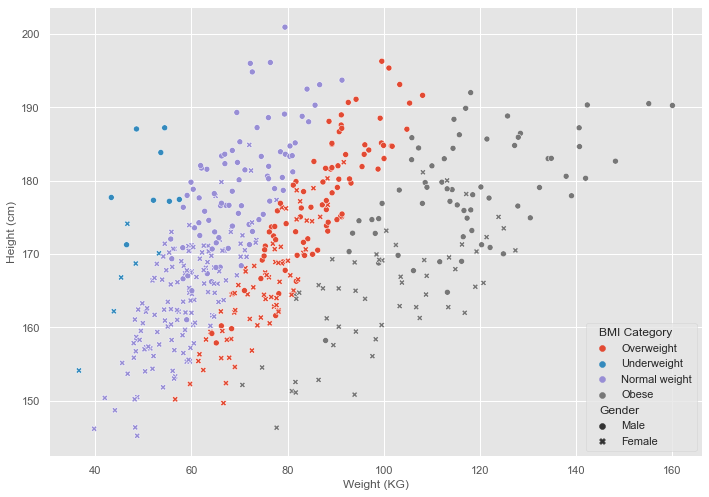

In [16]:
sns.scatterplot( x='Weight (KG)', y='Height (cm)', data=df, hue='BMI Category', style='Gender');

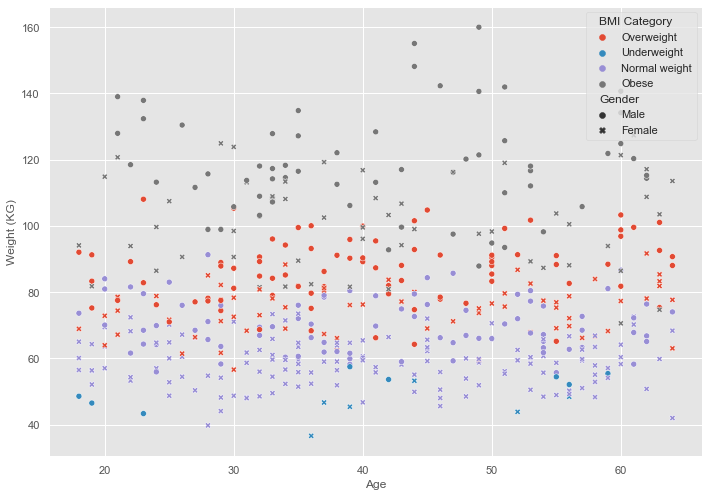

In [17]:
sns.scatterplot( x='Age', y='Weight (KG)', data=df, hue='BMI Category', style='Gender');

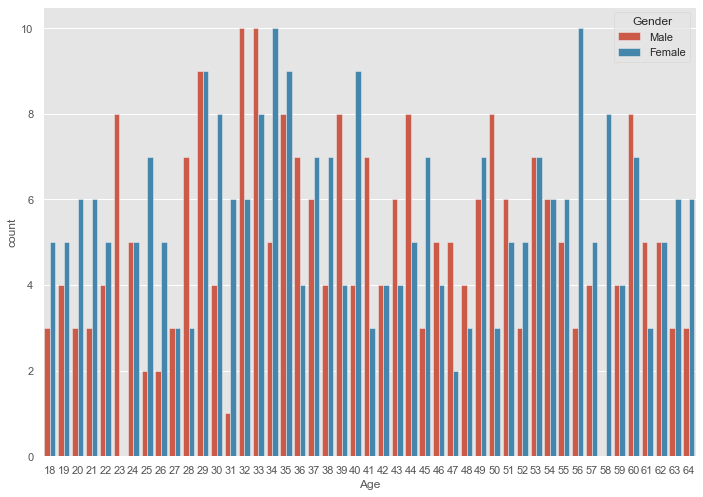

In [18]:
sns.countplot( x='Age', data=df, hue='Gender' );

### Showing final Data Frame

In [26]:
print(df)

     Gender  Age  Height (cm)   BMI Category  Weight (KG)
0      Male   37       180.84     Overweight       81.655
1      Male   19       184.21    Underweight       46.499
2    Female   26       167.21  Normal weight       54.440
3      Male   51       169.19          Obese      141.961
4    Female   22       171.57  Normal weight       68.189
..      ...  ...          ...            ...          ...
495    Male   43       175.72  Normal weight       74.919
496    Male   61       182.37          Obese      120.338
497  Female   18       148.49          Obese       94.126
498    Male   57       180.04  Normal weight       68.511
499    Male   62       178.60  Normal weight       65.089

[500 rows x 5 columns]


## Conclusion and Assessing the Synthetic Data

At this point I'm pretty happy with the relationship I have shown between Gender, Weight and Height and I think it is mostly a reasonable simulation.

Gender is probably the most reliable of the variables in the dataset as it is directly based on census data with age being very similar.

Height I am fairly confident is a good representation, while not based directly on Irish heights and instead based on worldwide heights due to availability of the information.

Where I am most skeptical is of my approach around getting BMI values, ideally it would have been better to determine weight as a function of Gender, Height and Age, but I wasn't able to find a reasonable dataset or paper that would show this relationship. Instead I relied on the proportion of the population that fall under different BMI categories and working back from this under the assumption that BMI within these categories is uniformly distributed, figured out the BMI and finally using this BMI to determine the individuals weight as we already have height.

With regards to age I am happy with how this turned out as I had a good dataset to base proportion of age by gender, unfortunately as mentioned above I wasn't able to determine how to reasonably have this impact weight, so ultimately age was only generated based off Gender but had no impact on any other variables. Looking at the above scatterplot for age against weight we can see the result of not having age affect weight as there is no relationship that can be seen.

### Areas to Improve On

As mentioned in the above conclusion the main issue with this dataset is regards generating the BMI/Weight data,  with the above I took a backwards approach of first determining BMI and then weight from that. Ideally instead would like to determine weight directly from values in the variables for Gender, Age and Height which would remove the need to generate BMI information and to make the few assumptions that I've included - namely that within BMI categories they are uniformly distributed and the fixed limits for the under weight and obese categories.

I did look at comparing using uniform distribution vs. normal distribution for determining BMI, but I ultimately chose to use uniform distribution for two reasons, first was with the normal distributions I had to make up mean and std. dev. for each BMI category and secondly for the scatterplot of height v. weight it led to stratification of the different categories where very clear lines ran through the dataset as BMI categories overlapped.

For an improved version I would like to look more indepth at what is an appropriate distribution for weight, from some reading I saw that perhaps a log normal or potentially multi peaked distribution would be more appropriate so this would certainly be an area that could have improved the final dataset.
In addition to this I would like to implement a better way for having multiple variables influence a single variable so that I would have some equation for weight being determined by gender + age + height, I know a reasonable approach for this would be to look at using multiple linear regression on some dataset where there is present gender, age, height and weight, however even after reading up on it and playing around with it I don't feel confident enough in an approach to include it as part of this project.